In [15]:
import tarfile
import os
from PIL import Image
import numpy as np
import re
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

import torch.nn.functional as F

In [16]:
# Set random seed for reproducibility
random_seed = 42
torch.backends.cudnn.enDatasetable = False
torch.manual_seed(random_seed)

In [17]:
def extract_label(image_name):
    """
    Extracts the label from the image file name using a regex pattern.
    
    Args:
        image_name (str): The name of the image file.
        
    Returns:
        str: The extracted label (the number before the underscore in the file name).
        None: If no match is found.
    """
    match = re.match(r'(\d+)_\d+\.jpg', image_name)
    if match:
        return match.group(1)
    return None



In [18]:
def read_tar_to_array(file):
    """
    Reads a tar file, extracts images, and converts them to arrays.
    Extracts labels from file names and converts them to an array.
    
    Args:
        file (str): Path to the tar file.
        
    Returns:
        list of PIL.Image.Image: List of images in PIL format.
        numpy.ndarray: Array of labels.
    """
    # Open the tar file
    tar = tarfile.open(file, "r:xz")
    
    # Lists to store images and labels
    image_list = []
    label_list = []
    
    # Iterate over the tar file
    for tarinfo in tar:
        tar.extract(tarinfo.name)  # Extract the file from the tar archive
        if tarinfo.name.endswith('.jpg'):  # Check if the file is a JPEG image
            # Open the image file and convert it to RGB format 
            image_list.append(Image.open(tarinfo.name).convert("RGB"))
            # Extract the label from the file name and append it to label_list
            label_list.append(tarinfo.name.split('_/')[1])
                              
    # Close the tar file
    tar.close()
    
    # Extract labels and convert to numpy array
    labels = np.array([i.split('_', 1)[0] for i in label_list])
    
    return image_list, labels

# Convert tar archive files into PIL objects and extract labels
test_img, test_labels = read_tar_to_array('./data/test_.tar.xz')
train_img, train_labels = read_tar_to_array('./data/train_.tar.xz')

# Check the length of the training and test datasets
print(len(test_img), len(test_labels), len(train_img), len(train_labels))

# Split the training data into training and validation sets
train_img, val_img, train_labels, val_labels = train_test_split(
    train_img, train_labels, test_size=0.2, random_state=random_seed, stratify=train_labels
)

# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image or numpy array to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize with mean and std for each channel
])

550 550 2204 2204


In [19]:
class BrazillianCoins(Dataset):
    def __init__(self, files, labels):
        """
        Dataset class for images. Transforms images (resizing, grayscale conversion,
        tensor conversion, and normalization) and prepares them for input into a CNN.
        
        Args:
            files (list of PIL.Image.Image): List of image objects.
            labels (list of str): List of labels corresponding to the images.
        """
        # Define the transformations: Resize, convert to grayscale, convert to tensor, and normalize
        self.transforms = transforms.Compose([
            transforms.Resize((128, 128)),          # Resize images to 128x128 pixels
            transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=([0.0827]), std=([0.1475]))  # Normalize the images with mean and std for grayscale
        ])

        self.files = files                # Store the list of image objects
        self.labels = labels              # Store the list of labels

    def __getitem__(self, idx):
        """
        Retrieve an image and its label at the specified index, apply transformations,
        and return the processed image and its label.
        
        Args:
            idx (int): Index of the item to retrieve.
        
        Returns:
            tuple: (transformed_image, label) where `transformed_image` is a tensor 
                   and `label` is an integer class label.
        """
        # Dictionary to convert string labels to integers
        class_dict = {'5': 0, '10': 1, '25': 2, '50': 3, '100': 4}
        
        file = self.files[idx]            # Get the image at the specified index
        img = self.transforms(file)       # Apply transformations to the image
        label = class_dict[self.labels[idx]]  # Convert the label to an integer
        
        return img, label

    def __len__(self):
        """
        Return the total number of images in the dataset.
        
        Returns:
            int: Number of items in the dataset.
        """
        return len(self.files)

In [20]:
# Instantiate dataset objects for training, testing, and validation
train_tensor = BrazillianCoins(train_img, train_labels)
val_tensor = BrazillianCoins(val_img, val_labels)
test_tensor = BrazillianCoins(test_img, test_labels)

In [21]:
# Set batch size for data loading
batch_size = 128

# Assuming train_tensor and train_labels are available as data and labels
X_train = train_tensor
y_train = train_labels  # These are the corresponding labels for your train data

# Initialize StratifiedShuffleSplit to split the dataset into training and validation
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # 80-20 train-val split

# Perform the split
for train_idx, val_idx in strat_split.split(X_train, y_train):
    X_train_stratified = Subset(train_tensor, train_idx)
    y_train_stratified = Subset(train_labels, train_idx)
    X_val_stratified = Subset(train_tensor, val_idx)
    y_val_stratified = Subset(train_labels, val_idx)

# Now create DataLoader for training and validation with the stratified subsets
train_loader = DataLoader(X_train_stratified, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(X_val_stratified, batch_size=batch_size, shuffle=False)

# Similarly, load the test dataset into a DataLoader
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)

# Create dictionaries to store loaders and dataset sizes for easy access
loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
sizes = {'train': len(train_idx), 'val': len(val_idx), 'test': len(test_tensor)}


In [22]:
class BrazilianCoinConvClassifier(nn.Module):
    def __init__(self, number_of_classes):
        """
        Initialize the convolutional neural network model for image classification.
        
        Args:
            number_of_classes (int): Number of output classes for classification.
        """
        super(BrazilianCoinConvClassifier, self).__init__()
        
        # Define the layers of the neural network
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)  # Added third conv layer
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1)  # Added fourth conv layer
        
        self.dropout1 = nn.Dropout(0.25)          # Dropout layer to prevent overfitting
        self.dropout2 = nn.Dropout(0.3)           # New dropout layer with 0.3 probability
        self.dropout3 = nn.Dropout(0.5)           # Another dropout layer with higher dropout rate
        
        # Only one fully connected layer now
        self.fc1 = nn.Linear(in_features=215296, out_features=number_of_classes)  # Output layer

    def forward(self, x):
        """
        Define the forward pass of the model, applying convolutional layers, activation functions,
        pooling, dropout, and fully connected layers.
        
        Args:
            x (Tensor): Input tensor (batch of images).
        
        Returns:
            Tensor: Output tensor after passing through the network.
        """
        x = self.conv1(x)               # Apply first convolutional layer
        x = F.relu(x)                   # Apply ReLU activation function
        x = self.conv2(x)               # Apply second convolutional layer
        x = F.relu(x)                   # Apply ReLU activation function
        x = F.max_pool2d(input=x, kernel_size=2)  # Apply max pooling with 2x2 kernel
        x = self.conv3(x)               # Apply third convolutional layer
        x = F.relu(x)                   # Apply ReLU activation function
        x = self.conv4(x)               # Apply fourth convolutional layer
        x = F.relu(x)                   # Apply ReLU activation function
        x = F.max_pool2d(input=x, kernel_size=2)  # Apply another max pooling
        
        x = self.dropout1(x)            # Apply dropout to reduce overfitting

        x = torch.flatten(x, 1)         # Flatten the tensor for fully connected layers
        x = self.fc1(x)                 # Directly apply output layer (no intermediate fully connected layer)
        output = F.log_softmax(x, dim=1)  # Apply log softmax activation function
        
        return output


In [23]:

def get_device():
    """
    Get the device to be used for tensor computations.
    Checks if CUDA (GPU) is available, otherwise defaults to CPU.
    
    Returns:
        torch.device: The device to be used (either "cuda" or "cpu").
    """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def bind_gpu(data):
    """
    Move the given data to the appropriate device (GPU or CPU).
    Handles both single tensors and collections (lists or tuples) of tensors.
    
    Args:
        data (Tensor or list of Tensors): Data to move to the device.
    
    Returns:
        Tensor or list of Tensors: Data moved to the device.
    """
    device = get_device()
    if isinstance(data, (list, tuple)):
        # Recursively move each element in the list or tuple to the device
        return [bind_gpu(data_elem) for data_elem in data]
    else:
        # Move the tensor to the device
        return data.to(device, non_blocking=True)

In [24]:
number_of_classes = 5
# Initialize the model with the specified number of output classes
model = BrazilianCoinConvClassifier(number_of_classes)

# Move the model to the appropriate device (GPU or CPU)
bind_gpu(model)
print(model)

BrazilianCoinConvClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=5, bias=True)
)


In [25]:
def count_parameters(model):
    """
    Count the total number of parameters in the model and print details for each layer.
    
    Args:
        model (nn.Module): The PyTorch model whose parameters are to be counted.
    
    Returns:
        int: Total number of parameters in the model.
    """
    total_params = sum(p.numel() for p in model.parameters())  # Total parameter count

    # Iterate through the layers of the model and print parameter details
    for name, layer in model.named_children():
        num_params = sum(p.numel() for p in layer.parameters())
        print(f"Layer: {name}, Parameters: {num_params}")

    return total_params


In [26]:
# Print the total number of parameters in the model and details for each layer
total_params = count_parameters(model)
print(f"Total Parameters: {total_params}")

Layer: conv1, Parameters: 320
Layer: conv2, Parameters: 18496
Layer: conv3, Parameters: 73856
Layer: conv4, Parameters: 295168
Layer: dropout1, Parameters: 0
Layer: dropout2, Parameters: 0
Layer: dropout3, Parameters: 0
Layer: fc1, Parameters: 1076485
Total Parameters: 1464325


In [27]:
def train_classification(model, criterion, optimizer, number_of_epochs, train_loader, validation_loader):
    """
    Train the classification model using the provided data loader, loss function, and optimizer.
    
    Args:
        model (nn.Module): The model to be trained.
        criterion (nn.Module): The loss function used for training.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        number_of_epochs (int): Number of epochs to train the model.
        train_loader (DataLoader): DataLoader providing the training data.
        validation_loader (DataLoader): DataLoader providing the validation data.
    
    Returns:
        tuple: (train_losses, train_accuracies, valid_losses, valid_accuracies) where:
            - train_losses: List of average training loss values for each epoch
            - train_accuracies: List of training accuracy values for each epoch
            - valid_losses: List of average validation loss values for each epoch
            - valid_accuracies: List of validation accuracy values for each epoch
    """
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    device = get_device()  # Get the device to be used for training

    for epoch in range(number_of_epochs):
        print(f"Epoch [{epoch + 1}/{number_of_epochs}]")

        # Training phase
        model.train()  # Set the model to training mode
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct_train += (predicted.squeeze() == labels).sum().item()
            total_train += labels.size(0)

        # Compute average training loss and accuracy
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():  # No gradient computation during validation
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                valid_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                correct_valid += (predicted.squeeze() == labels).sum().item()
                total_valid += labels.size(0)

        # Compute average validation loss and accuracy
        avg_valid_loss = valid_loss / len(validation_loader)
        valid_accuracy = correct_valid / total_valid
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(valid_accuracy)

        # Print the results
        print(f'Accuracy: train {train_accuracy:.4f} \t validation: {valid_accuracy:.4f}')
        print(f'Loss: train {avg_train_loss:.4f} \t validation: {avg_valid_loss:.4f}')

    return train_losses, train_accuracies, valid_losses, valid_accuracies


In [29]:
# Define the number of epochs for training
N_EPOCHS = 60

# Define the loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()  # Used for classification problems with multiple classes
optimizer = optim.Adam(params=model.parameters())
# Train the model and get the losses and accuracies for training and validation
train_losses, train_accuracies, val_losses, val_accuracies = train_classification(
    model, criterion, optimizer, N_EPOCHS, train_loader, val_loader
)


Epoch [1/60]
Accuracy: train 0.1936 	 validation: 0.2068
Loss: train 2.7405 	 validation: 1.6120
Epoch [2/60]
Accuracy: train 0.2050 	 validation: 0.2323
Loss: train 1.6090 	 validation: 1.6311
Epoch [3/60]
Accuracy: train 0.2177 	 validation: 0.2210
Loss: train 1.6161 	 validation: 1.6361
Epoch [4/60]
Accuracy: train 0.2362 	 validation: 0.2011
Loss: train 1.6167 	 validation: 1.6519
Epoch [5/60]
Accuracy: train 0.2184 	 validation: 0.1983
Loss: train 1.5947 	 validation: 1.6132
Epoch [6/60]
Accuracy: train 0.2702 	 validation: 0.2238
Loss: train 1.5870 	 validation: 1.6034
Epoch [7/60]
Accuracy: train 0.2851 	 validation: 0.2351
Loss: train 1.5139 	 validation: 1.6697
Epoch [8/60]
Accuracy: train 0.2823 	 validation: 0.2323
Loss: train 1.5745 	 validation: 1.6032
Epoch [9/60]
Accuracy: train 0.2936 	 validation: 0.2408
Loss: train 1.5645 	 validation: 1.6269
Epoch [10/60]
Accuracy: train 0.3021 	 validation: 0.2323
Loss: train 1.5103 	 validation: 1.6475
Epoch [11/60]
Accuracy: train

In [30]:
def plot_classification(loss, accuracy, loss_title='Training Loss', accuracy_title='Training Accuracy'):
    """
    Plot training loss and accuracy over epochs.
    
    Args:
        loss (list): List of loss values for each epoch.
        accuracy (list): List of accuracy values for each epoch.
        loss_title (str): Title of the loss plot.
        accuracy_title (str): Title of the accuracy plot.
    """
    number_of_epochs = len(loss)  # Number of epochs is the length of the loss list

    # Plot training loss
    plt.title(loss_title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(number_of_epochs), loss, label='Loss')
    plt.legend()
    plt.show()

    # Plot training accuracy
    plt.title(accuracy_title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(range(number_of_epochs), accuracy, label='Accuracy')
    plt.legend()
    plt.show()


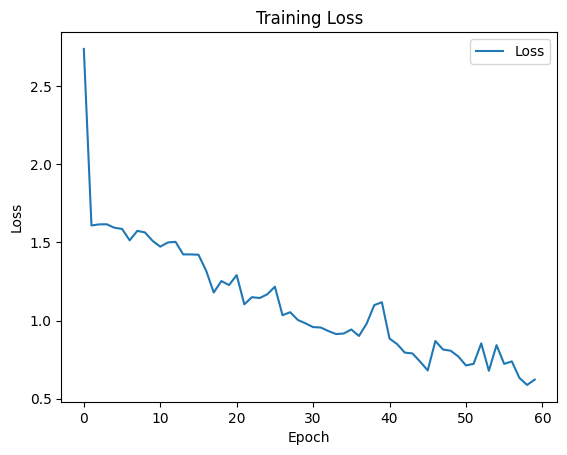

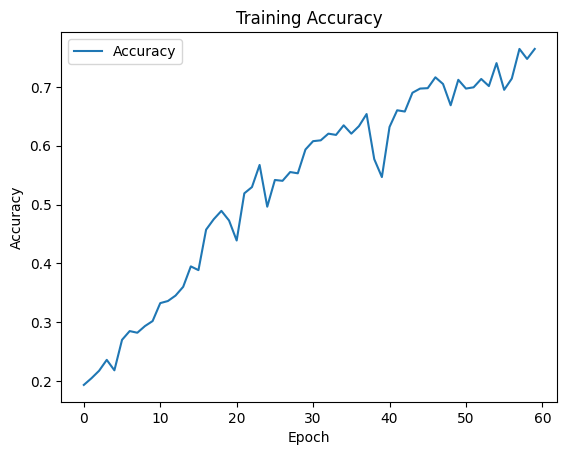

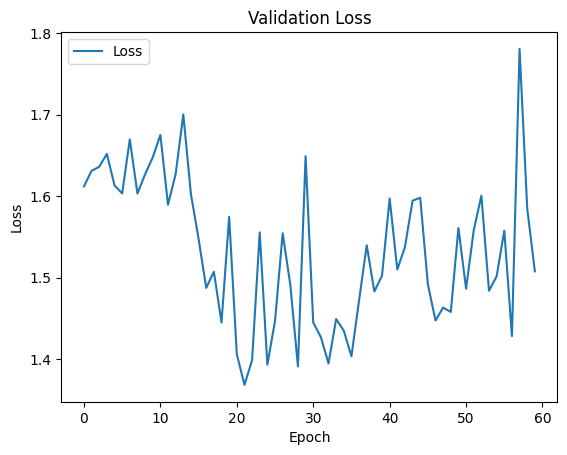

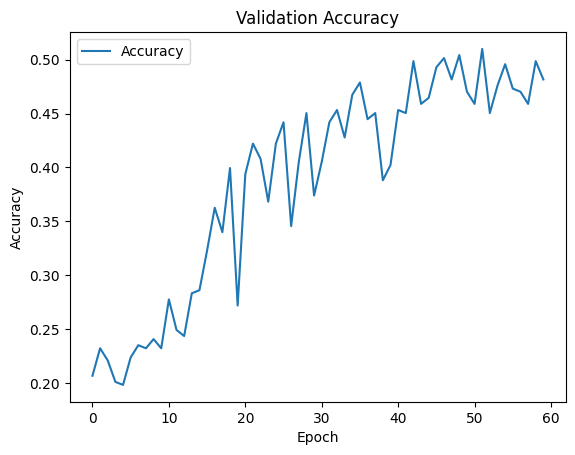

In [31]:
# Plot the training and validation loss and accuracy
plot_classification(train_losses, train_accuracies, 'Training Loss', 'Training Accuracy')
plot_classification(val_losses, val_accuracies, 'Validation Loss', 'Validation Accuracy')

In [32]:
def evaluate_classification(model, criterion, loader, multiclass=False):
    """
    Evaluate the classification model on a given dataset.
    
    Args:
        model (nn.Module): The model to be evaluated.
        criterion (nn.Module): The loss function used for evaluation.
        loader (DataLoader): DataLoader providing the evaluation data.
        multiclass (bool): Indicates if the task is multiclass classification (default is False).
    
    Returns:
        tuple: (avg_loss, accuracy) where avg_loss is the average loss and accuracy is the accuracy of the model.
    """
    device = get_device()  # Get the device to be used (CPU or GPU)
    model.to(device)  # Ensure model is on the same device as the inputs
    model.eval()  # Set the model to evaluation mode
    
    total_loss = 0.0  # Accumulate total loss
    total_correct = 0  # Accumulate number of correct predictions
    total_samples = 0  # Total number of samples processed
    predicted_labels, true_labels = [], []  # Lists to store predicted and true labels

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, labels in loader:
            # Move inputs and labels to the appropriate device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Perform forward pass to get model outputs
            outputs = model(inputs)
            
            # Compute and accumulate loss
            total_loss += criterion(outputs.squeeze(), labels).item()

            # Make predictions based on the outputs
            if multiclass:
                # For multiclass classification, use argmax to get the predicted class
                predicted = torch.argmax(outputs, dim=1)
            else:
                # For binary classification, threshold the outputs to get predictions
                predicted = (outputs > 0.5).float()
            
            # Collect predicted and true labels for metrics calculation
            predicted_labels.extend(predicted.squeeze().tolist())
            true_labels.extend(labels.tolist())

            total_samples += labels.size(0)
            total_correct += (predicted.squeeze() == labels).sum().item()

    # Compute evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    
    # Print evaluation metrics
    print(f'Model evaluation on: {loader}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

    # Compute average loss and accuracy
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x000002372DDABA90>
Accuracy: 0.7979
Precision: 0.8012
Recall: 0.7979
F1 Score: 0.7988


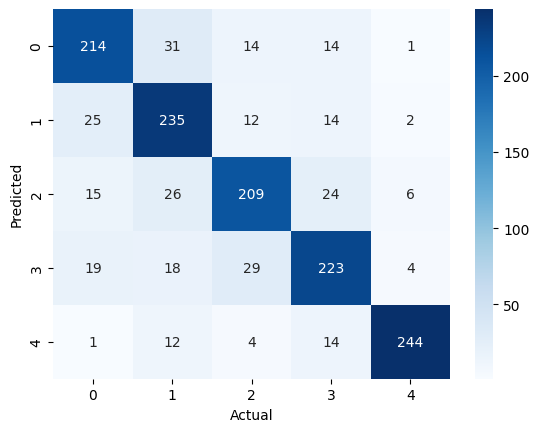

Train Set: Loss: 0.6432, Accuracy: 0.7979
Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x0000023846DF6AD0>
Accuracy: 0.4855
Precision: 0.5000
Recall: 0.4855
F1 Score: 0.4894


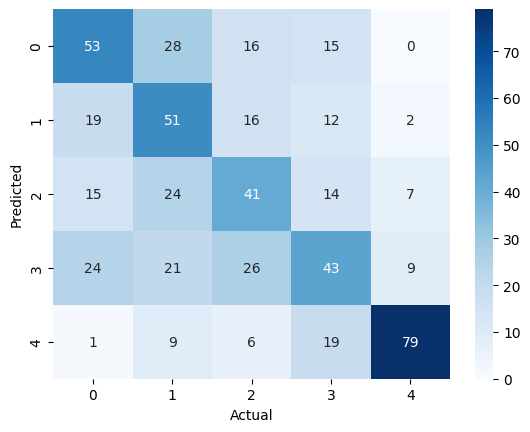

Test Set: Loss: 1.7233, Accuracy: 0.4855


In [33]:
# Evaluate the model on the training set and print results
train_loss, train_accuracy = evaluate_classification(model, criterion, train_loader, multiclass=True)
print(f'Train Set: Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')

# Evaluate the model on the test set and print results
test_loss, test_accuracy = evaluate_classification(model, criterion, test_loader, multiclass=True)
print(f'Test Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

In [34]:
def save_model(model, filepath):
    """
    Saves the model's state_dict to the specified file path.
    
    Args:
        model (torch.nn.Module): The model to save.
        filepath (str): The path where the model will be saved.
    """
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model_class, filepath, number_of_classes):
    """
    Loads the model's state_dict from the specified file path into a new model instance.
    
    Args:
        model_class (type): The class of the model to load.
        filepath (str): The path where the model's state_dict is stored.
        number_of_classes (int): Number of output classes for the model.
    
    Returns:
        torch.nn.Module: The loaded model with weights.
    """
    model = model_class(number_of_classes)  # Create a new instance of the model class
    model.load_state_dict(torch.load(filepath))  # Load the state dict into the model
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {filepath}")
    return model

In [35]:
save_model(model, "./modelv2")

Model saved to ./modelv2


In [36]:
model=load_model(BrazilianCoinConvClassifier, "./modelv2", 5)

Model loaded from ./modelv2
